# Filtering expanded dataset

## Core Imports

In [1]:
# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdqueries
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import IPythonConsole

DIM    = 300
ASPECT = 3/2
IPythonConsole.molSize = (int(ASPECT*DIM), DIM)   # Change image size

# Custom imports
from polymerist.monomers import specification
from polymerist.rdutils.smileslib import queries

# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')
# RXN_FILES_DIR = Path('rxn_smarts')

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Loading desired dataset

In [2]:
input_data_path = FMT_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers.csv'
df = pd.read_csv(input_data_path)

## Defining queries for illegal chemistries

In [3]:
illegal_chem_queries = {
    'silicon' : Chem.MolFromSmarts('[Si]'),
    'sulfur'  : Chem.MolFromSmarts('[S]'),
    'metal'   : queries.SPECIAL_QUERY_MOLS['metal'],
    # 'halogen' : queries.SPECIAL_QUERY_MOLS['halogen'],
}

## Loading and backmapping premade reaction functional groups and templates

In [4]:
rxn_backmap = { # map NREL dataset mechanism names to pre-made rxn template names
    'amide'     : 'polyamide',
    'carbonate' : 'polycarbonate_phosgene',
    'ester'     : 'polyester',
    'imide'     : 'polyimide',
    'urethane'  : 'polyurethane_isocyanate',
    'NIPU'      : 'polyurethane_nonisocyanate',
    'vinyl'     : 'polyvinyl_head_tail'
}
assert(set(df['mechanism'].unique()).issubset(set(rxn_backmap.keys()))) # verify that we've mapped all reactions

with (RXN_FILES_DIR / 'rxn_backmap.json').open('w') as backmap_file:
    json.dump(rxn_backmap, backmap_file, indent=4)

In [5]:
with (RXN_FILES_DIR / 'fn_group_smarts.json').open('r') as file:
    fn_group_smarts  = json.load(file)
    fn_group_queries = {
        group_name : Chem.MolFromSmarts(smarts)
            for group_name, smarts in fn_group_smarts.items()
    }

with (RXN_FILES_DIR / 'rxn_groups.json').open('r') as file: # load table of functional group for each reaction
    rxn_groups = json.load(file)

## Utility functions

In [6]:
from enum import Enum, auto

@dataclass
class MonomerInfo:
    '''For encapsulating salient info about an individual monomer'''
    position      : int
    smiles        : str
    fn_group_name : str
    IUPAC_name    : str

class FilterRejectionReason(Enum):
    '''For capturing information about which filtering step a monomer didn't pass'''
    BAD_NUM_MONOMERS      = auto()
    ILLEGAL_ATOMS         = auto()
    NO_RXN_TEMPLATE_MATCH = auto()
    BAD_NUM_FN_GRPS       = auto()
    NO_IUPAC_NAME         = auto()

In [7]:
import cirpy
import pubchempy as pcp

def get_IUPAC_name(smiles : str, pc_prop_name : str='IUPACName') -> Optional[str]:
    '''Takes the SMILES string representing a molecule and attempts to fetch its IUPAC name from NIH CACTUS and/or PubChem
    Returns the fetched IUPAC name as a str, or NoneType if both queries fail'''
    # Open with NIH query (fastest method), return name if found...
    iupac_name = cirpy.resolve(smiles, 'iupac_name')
    if iupac_name is not None:
        return iupac_name 
    
    # ...otherwise, search through PubChem Compound queries for a matching results
    for prop_query in pcp.get_properties(pc_prop_name, smiles, namespace='smiles'):
        if pc_prop_name in prop_query:
            return prop_query[pc_prop_name]
    else:
        return None # TODO : add ChemSpider once I can obtain an API key (https://chemspipy.readthedocs.io/en/latest/guide/intro.html#apikey) 

In [12]:
from polymerist.monomers import specification
from polymerist.maths.combinatorics.sequences import bin_ids_forming_sequence

def process_monomer_input(smiles : str, mech_name : str) -> Union[FilterRejectionReason, list[MonomerInfo]]:
    '''For screening and expanding SMILES input to the MD polymer building workflow'''
    # 1) Determine number of distrinct monomers in passed SMILES string
    indiv_smiles = smiles.split('.') # opting for direct string-based approach here rather than RDKit Mol fragmenting for speed, and to avoid clunky str -> Mol -> str conversion
    num_monomers = len(indiv_smiles)
    if num_monomers != 2:
        return FilterRejectionReason.BAD_NUM_MONOMERS
    
    # Generate expanded SMILES string and corresponding RDKit Mol for all monomers
    exp_smiles         : list[str     ] = []
    indiv_monomers     : list[Chem.Mol] = []
    mono_group_choices : list[Iterable[str]] = []
    
    for smi in indiv_smiles: # wait to expand SMILES until after count filtering for speed
        exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
        monomer = Chem.MolFromSmiles(exp_smi, sanitize=False)

        # 2) Catch monomers with illegal atoms or, if none are present, generate expanded SMILES string and corresponding RDKit Mol for all monomers
        if any(queries.matching_labels_from_substruct_dict(monomer, illegal_chem_queries)): # if any illegal atoms are detected in the current monomer, return and exit
            return FilterRejectionReason.ILLEGAL_ATOMS

        exp_smiles.append(exp_smi)
        indiv_monomers.append(monomer)
        mono_group_choices.append(queries.matching_labels_from_substruct_dict(monomer, fn_group_queries)) # generate ordered list of functional group choice bins

    # 3) Determine if monomer functionalizations match the advertised rxn, and if so in what order they should appear
    reactive_groups : list[str] = rxn_groups[rxn_backmap[mech_name]]
    all_indices     : set[int]  = set(range(num_monomers))
    for mono_order in bin_ids_forming_sequence(sequence=reactive_groups, choice_bins=mono_group_choices):
        if set(mono_order) == all_indices: # check to avoid duplication for multifunctional monomers
            break # exit loop when first valid order is found
    else:
        return FilterRejectionReason.NO_RXN_TEMPLATE_MATCH
    
    # produce monomers based on a valid ordering if one is found
    mono_info_list : list[MonomerInfo] = []
    for i, mono_fn_group in zip(mono_order, reactive_groups, strict=True): # strict just gives one further safeguard that a 1:1 reactive group to monomer mapping has been found
        monomer = indiv_monomers[i]
        # 4) Determine if all monomers are only have the desired functionalization numbers 
        if not (
            (queries.num_substruct_queries(monomer, fn_group_queries[mono_fn_group], uniquify=True ) == 2) or \
            (queries.num_substruct_queries(monomer, fn_group_queries[mono_fn_group], uniquify=False) == 2) # special case for phosgene
        ): 
            print(mono_fn_group)
            display(monomer)
            return FilterRejectionReason.BAD_NUM_FN_GRPS
        
        # 5) Query IUPAC names for each monomer - NOTE: not done in the monomer expansion loop as the name query is the slowest step and should preferably alled as few times as possible
        iupac_name = get_IUPAC_name(exp_smiles[i])
        if iupac_name is None:
            return FilterRejectionReason.NO_IUPAC_NAME
        
        # if a monomer has gotten here, that means it's passed!
        mono_info = MonomerInfo(
            position=i,
            smiles=exp_smiles[i],
            fn_group_name=mono_fn_group,
            IUPAC_name=iupac_name
        )
        mono_info_list.append(mono_info)

    return mono_info_list

# Filter dataset

## Generate filtered Series (either error codes or MonomerInfo) from initial dataset

Output()

amine

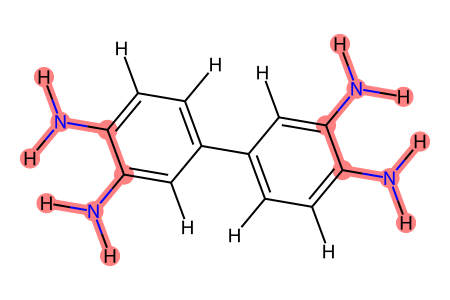

carboxyl

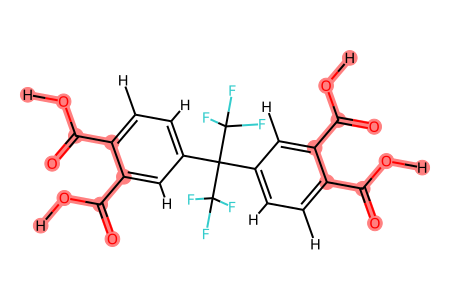

carboxyl

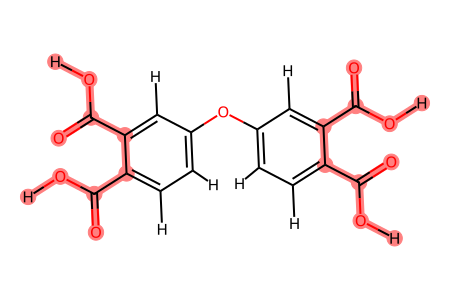

carboxyl

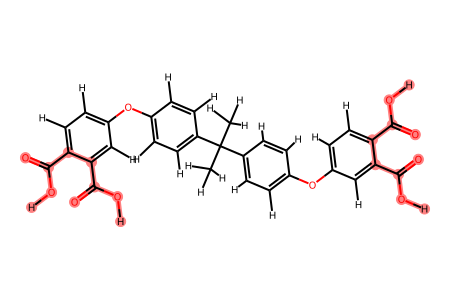

carboxyl

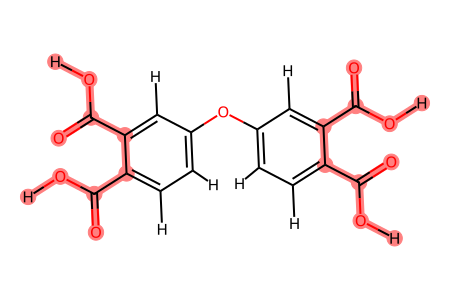

terminal_alkene

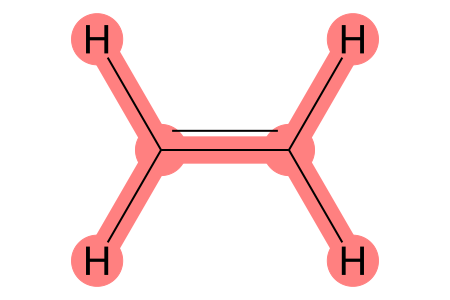

carboxyl

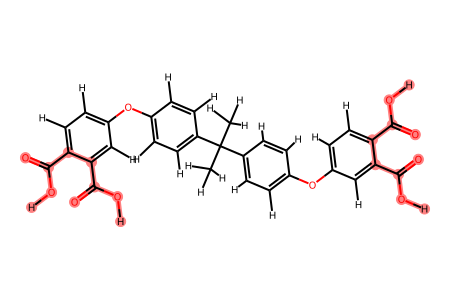

carboxyl

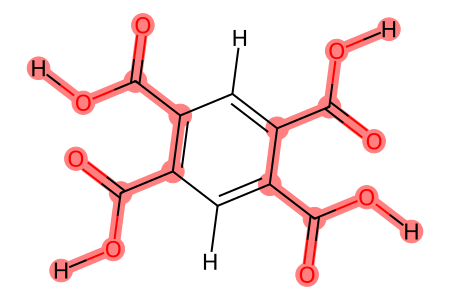

terminal_alkene

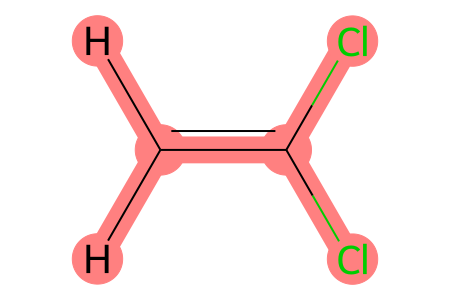

amine

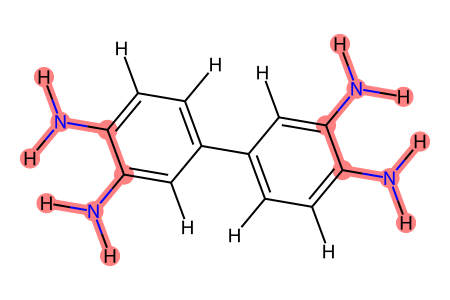

carboxyl

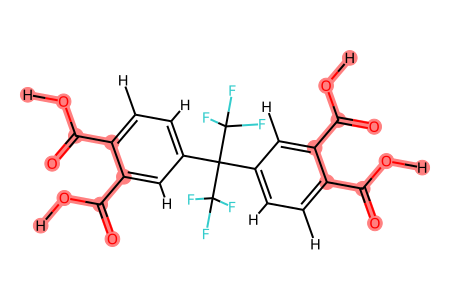

amine

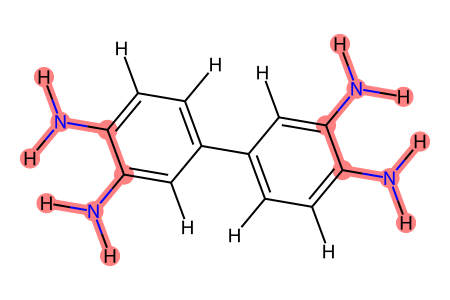

carboxyl

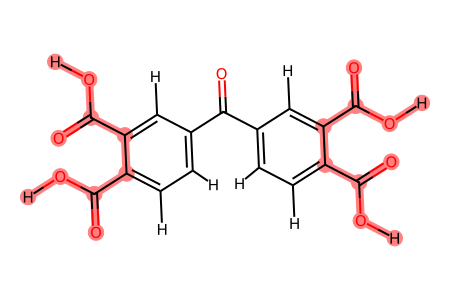

carboxyl

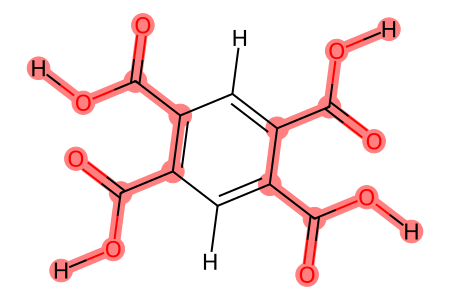

terminal_alkene

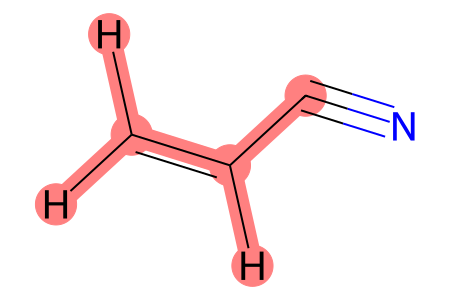

terminal_alkene

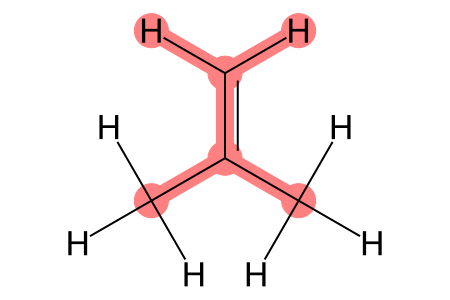

terminal_alkene

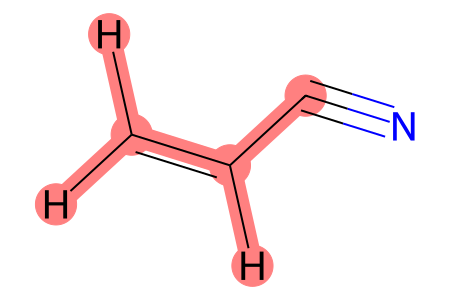

carboxyl

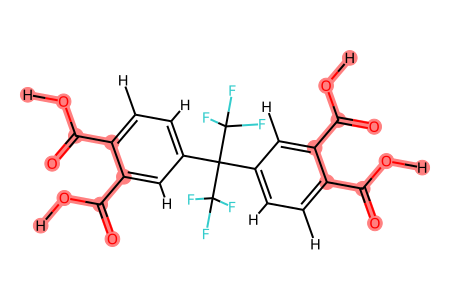

carboxyl

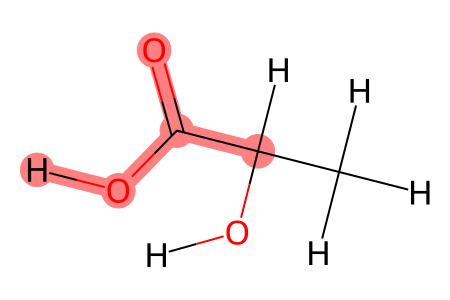

carboxyl

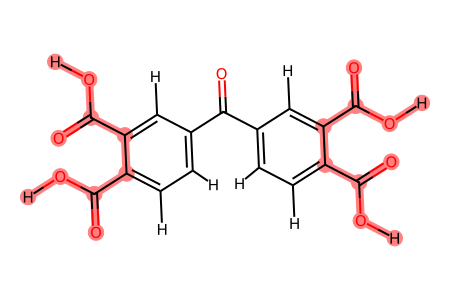

In [13]:
from rich.progress import track

targ_df = df
# targ_df = df.head(30)

proc_output = []
for (i, row) in track(targ_df.iterrows(), total=len(targ_df), description='Processing SMILES dataset...'):
    proc = process_monomer_input(row.smiles_monomer, row.mechanism)
    proc_output.append(proc)

proc_output = pd.Series(proc_output) # convert from list to Series, partition by failure state
failed = proc_output.map(lambda out : isinstance(out, FilterRejectionReason))
fails = proc_output[ failed]
succs = proc_output[~failed]

## Expand successful monomers into labelled DataFrame

In [10]:
def expand_mono_info_list(all_info : list[MonomerInfo]) -> list[str]:
    return {
        f'{attr}_{mono_info.position}' : getattr(mono_info, attr)
            for mono_info in all_info
                for attr in ('smiles', 'fn_group_name', 'IUPAC_name')
    }

succs_as_dict = succs.map(expand_mono_info_list)
succs_df = pd.DataFrame.from_records(succs_as_dict.values, index=succs_as_dict.index)
succs_df

,smiles_1,fn_group_name_1,IUPAC_name_1,smiles_0,fn_group_name_0,IUPAC_name_0
0,[H]-[O]-[C]1=[C](-[H])-[C](-[H])=[C](-[C](-[C]...,hydroxyl,"4-[1,1,1,3,3,3-hexafluoro-2-(4-hydroxyphenyl)p...",[O]=[C](-[Cl])-[Cl],acyl_chloride,Carbonyl dichloride
6,[H]-[O]-[C]1=[C](-[C](-[H])(-[H])-[H])-[C](-[H...,hydroxyl,"4-[2-(4-hydroxy-3,5-dimethylphenyl)propan-2-yl...",[O]=[C](-[Cl])-[Cl],acyl_chloride,Carbonyl dichloride
7,[H]-[C]1=[C]2-[C](=[O])-[O]-[C](=[O])-[C]-2=[C...,anhydride,"5-[2-(1,3-dioxo-2-benzofuran-5-yl)-1,1,1,3,3,3...",[H]-[C]1=[C](-[H])-[C](-[H])=[C]2-[C](=[C]-1-[...,amine,4-[9-(4-aminophenyl)fluoren-9-yl]aniline
9,[H]-[C]1=[C](-[O]-[C]2=[C](-[C](-[C](-[H])(-[H...,amine,"4-N-(4-aminophenyl)-4-N-[4-(2,4,6-tritert-buty...",[H]-[C]1=[C](-[O]-[C]2=[C](-[H])-[C](-[H])=[C]...,anhydride,"5-[(1,3-dioxo-2-benzofuran-5-yl)oxy]-2-benzofu..."
10,[H]-[C]1=[C](-[C](=[O])-[C]2=[C](-[H])-[C](-[C...,anhydride,"5-[3-tert-butyl-5-(1,3-dioxo-2-benzofuran-5-ca...",[H]-[C]1=[C](-[H])-[C](-[N](-[H])-[H])=[C](-[H...,amine,"benzene-1,3-diamine"
...,...,...,...,...,...,...
455,[H]-[C]1=[C]2-[C](=[O])-[O]-[C](=[O])-[C]-2=[C...,anhydride,"5-[2-(1,3-dioxo-2-benzofuran-5-yl)-1,1,1,3,3,3...",[H]-[C]1=[C](-[O]-[C]2=[C](-[H])-[C](-[H])=[C]...,amine,4-[4-[2-[4-(4-aminophenoxy)phenyl]propan-2-yl]...
457,[H]-[C]1=[C]2-[C](=[O])-[O]-[C](=[O])-[C]-2=[C...,anhydride,"5-[2-(1,3-dioxo-2-benzofuran-5-yl)-1,1,1,3,3,3...",[H]-[C]1=[C](-[N](-[H])-[H])-[C](-[C](-[H])(-[...,amine,"4-[2-(4-amino-3-methylphenyl)-1,1,1,3,3,3-hexa..."
458,[H]-[C]1=[C](-[C](=[O])-[C]2=[C](-[H])-[C](-[H...,anhydride,"5-(1,3-dioxo2-benzofuran-5-carbonyl)-2-benzofu...",[H]-[C]1=[C](-[C](-[H])(-[H])-[H])-[C](-[N](-[...,amine,"2,4,6-Trimethylbenzene-1,3-diamine"
462,[H]-[O]-[C]1=[C](-[H])-[C](-[H])=[C](-[C]2(-[C...,hydroxyl,4-[1-(4-hydroxyphenyl)cycloheptyl]phenol,[O]=[C](-[Cl])-[Cl],acyl_chloride,Carbonyl dichloride


## Show distribution of failure cases

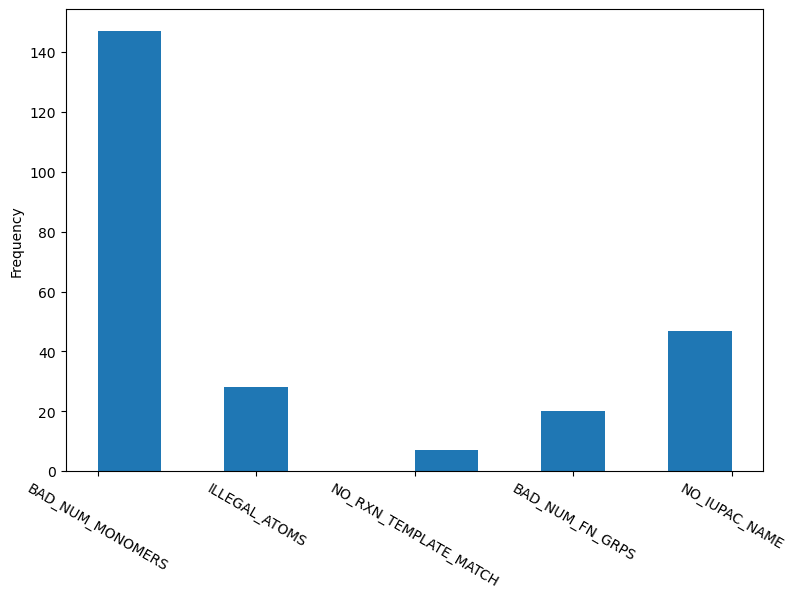

In [11]:
dim = 6
aspect= 3/2

plt.figure(figsize=(dim*aspect, dim))

ax = fails.map(lambda x : x.value).plot(kind='hist')
ax.set_xticks([i.value for i in FilterRejectionReason])
ax.set_xticklabels([i.name for i in FilterRejectionReason], rotation=-30)

plt.show()

In [14]:
conc = pd.concat([succs_df, df.loc[succs_df.index]], axis=1)
conc.to_csv('test.csv')

## Compare with prior iteration

In [ ]:
p = PROC_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers_FILTERED.csv'
d2 = pd.read_csv(p, index_col=0)
d2[['smiles_expanded_monomer_1', 'smiles_expanded_monomer_2', 'IUPAC_monomer_1', 'IUPAC_monomer_2']]

In [ ]:
for (i, row) in df.loc[d2.index.symmetric_difference(succs.index)].head(10).iterrows():
    display(Chem.MolFromSmiles(row.smiles_monomer))

In [ ]:
q = df.loc[succs_df.index]
q.mechanism.map(lambda x : x not in ['imide', 'vinyl']).sum()

In [ ]:
i = d2.index.symmetric_difference(succs_df.index)
df.loc[i].mechanism.unique()

In [ ]:
d2.iloc[succs_df.index.to_list()]

## Save filtered DataFrame for next steps to avoid reprocessing

In [16]:
out_data_path = PROC_DATA_DIR / f'{input_data_path.stem}_FILTERED_NEW{input_data_path.suffix}'
conc.to_csv(out_data_path)